### Ce notebook traite les données de comptage de trafic de Montpellier Métropole
et 
 in : https://data.montpellier3m.fr/dataset/comptage-vehicules-particuliers-de-montpellier    
 out : GeoJSON des comptages MJA jo et tcj par année, plus une comptage donnant le débit journalier maximum atteint 
 

## 0. initialisations

In [1]:
# pipeline parameters (values will be replaced by papermill when you run the compute.sh script in a docker container, or launch the pipeline)
# the parameters below are used when you test the notebook on jupyter 
# because this cell has a tag "parameters" https://papermill.readthedocs.io/en/latest/usage-parameterize.html
# you will have to download the data beforehand in the directories 
# pour ce notebook on n'utilise pas download.sh ne fait rien, on télécharge les données dans le notebook
# donc SOURCE_DIR ne sert à rien mais il faut que le directory indiqué existe sinon le pipeline plante.
PARAMETER_PROFILE_FILE="../3Mdata/3M.json"
SOURCE_DIR = "../3Mdata"
TARGET_DIR = "../3Mdata/trafic"
debug=False

In [2]:
import sys
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(format="%(levelname)s:%(name)s:%(asctime)s:%(message)s",level=logging.WARNING,stream=sys.stdout)
# Use stderr if script outputs data to stdout.

In [3]:
from pathlib import Path
import json

import pandas as pd
import numpy as np
import geopandas as gpd
#import matplotlib

# choix de la lib gtfs_kit, peut être moins performante que partridge mais maintenue semble-t-il
import gtfs_kit as gk


/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/tomm/comptages_3M/.venv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [4]:

import shapely

gpd.options.use_pygeos = True
from pygeos.io import from_wkt

if debug:
    import folium


/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/tomm/comptages_3M/.venv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## 1. lecture des fichiers de comptage routier
URL en dur pour l'instant, sans fichier de paramètres

In [5]:
# load parameters from parameter profile file
#with open(PARAMETER_PROFILE_FILE, 'rt', encoding='UTF-8') as fd:
#    indicator_parameters = json.load(fd)
#GTFS_URL = indicator_parameters.get("GTFS")

In [6]:
COMPTAGES_URL="https://data.montpellier3m.fr/sites/default/files/ressources/MMM_MTP_Comptage.csv"
FILAIRE_URL="https://data.montpellier3m.fr/sites/default/files/ressources/OSM_MMM_CorrespondanceFilaire.geojson"

In [7]:


COMPTAGES = pd.read_csv(COMPTAGES_URL)

## 1.1. lecture des données de COMPTAGES, extraction des MJA sens cumulés par année
https://r4ds.had.co.nz/tidy-data.html
    Each variable must have its own column.
    Each observation must have its own row.
    Each value must have its own cell.

In [8]:
COMPTAGES.shape
# 9552 lignes COMPTAGES
#COMPTAGES[COMPTAGES['libelle_groupage']=='Sens cumulés'].shape
#2409 lignes concernent des chiffres en sens cumulés


(9552, 19)

In [9]:
#COMPTAGES.columns

Index(['objectid', 'nom_voie', 'id_centrale', 'code_centrale', 'id_canal',
       'code_canal', 'libelle_groupage', 'annee', 'horodate',
       'descriptif_periode', 'hp_johvs_matin', 'hp_johvs_soir', 'mja_jo',
       'mja_tcj', 'tir_tcj', 'v85ma_tcj', 'vtma_tcj', 'mja_pl_tcj',
       'objectid_publication'],
      dtype='object')

In [9]:
code_centrale=list(COMPTAGES.code_centrale)
id_centrale=list(COMPTAGES.id_centrale)
code_canal=list(COMPTAGES.code_canal)
horodate=list(COMPTAGES.horodate)
descriptif_periode=list(COMPTAGES.descriptif_periode)

In [11]:
#len(set(code_centrale))
#len(set(code_canal))
#len(set(horodate))
#len(set(descriptif_periode))
#len(set(id_centrale))
# 1513 valeurs de code_centrale, 1511 valeurs de id_centrale... 9552 lignes
# 10 valeurs de code_canal, 0 à 8 + Z pour sens cumulés
# 2203 horodates, 1853 descriptif période


In [12]:
#import matplotlib
#from matplotlib import pyplot

In [10]:
# on ne garde que le cumul des comptages dans les 2 sens
QT=COMPTAGES[COMPTAGES['libelle_groupage']=='Sens cumulés'][['nom_voie','code_centrale','horodate','annee','descriptif_periode','mja_jo','mja_tcj']]

In [11]:
QTpm=QT.groupby(['code_centrale','annee']).mean().reset_index()
# on fait la moyenne des comptages existants pour chaque année

In [12]:
QTpm['annee']=pd.to_datetime(QTpm.annee,format="%Y")

In [16]:
#QTpm[['mja_jo','code_centrale','annee']].pivot(index=['annee'],columns=['code_centrale']).plot(legend=False)

In [15]:
#QTpm a 1944 lignes, annee de 2012 à 2022, 2 colonnes mjo jo et tcj
# len(QTpm['code_centrale'].unique())  # 1157 code centrale différents avec des données annuelles sous sens cumulés, contre 1513 au total

code_centrale      annee   mja_jo  mja_tcj
0                 100217 2020-01-01    724.0    568.0
1                 100352 2018-01-01   1453.0   1304.0
2                 100352 2019-01-01   2181.0   1854.0
3                 100352 2020-01-01   1852.0   1622.0
4                 100352 2021-01-01   2257.0   1975.0
...                  ...        ...      ...      ...
1939  QUAI DU VERDANSOÜ@ 2019-01-01      NaN      NaN
1940               TEST1 2019-01-01   7806.0   7191.0
1941               TEST2 2018-01-01  20322.0  18123.0
1942           TanneursV 2019-01-01   1965.0   1522.0
1943                test 2022-01-01   1646.0   1427.0

[1944 rows x 4 columns]

In [13]:
QTpm['an']=QTpm.annee.apply(lambda x: str(x)[0:4])

In [14]:
# on réorganise la donnée pour avoir une colonne par année
QTpman=QTpm.pivot_table(index=['code_centrale'],columns=['an'], values=['mja_jo','mja_tcj'])

In [15]:
QTpman.columns =QTpman.columns.map('_'.join)

In [16]:
QTpman=QTpman.reset_index()

In [17]:
import statistics
QTpman['mja_m']=QTpman.apply(lambda x: np.nanmax([x.mja_jo_2012, x.mja_jo_2013,x.mja_jo_2014,x.mja_jo_2015,x.mja_jo_2016,x.mja_jo_2017,x.mja_jo_2018,
x.mja_jo_2019,x.mja_jo_2020,x.mja_jo_2021,x.mja_jo_2022])
                            , axis=1)

/tmp/ipykernel_224836/3231511976.py:2: RuntimeWarning: All-NaN axis encountered
  QTpman['mja_m']=QTpman.apply(lambda x: np.nanmax([x.mja_jo_2012, x.mja_jo_2013,x.mja_jo_2014,x.mja_jo_2015,x.mja_jo_2016,x.mja_jo_2017,x.mja_jo_2018,


In [31]:
#QTpman[QTpman.mja_m>50000]

code_centrale  mja_jo_2012  mja_jo_2013  mja_jo_2014  mja_jo_2015  \
131          13029          NaN      56385.0      64497.0          NaN   
233         145411          NaN          NaN          NaN          NaN   
570          34542          NaN      61532.0      27839.0          NaN   
633          39226          NaN      26563.0      54812.0      31131.0   
639           4032          NaN      67945.0      67321.0      69283.0   
673          42210          NaN          NaN          NaN          NaN   
682          43268          NaN          NaN      65788.0          NaN   
800           4920          NaN      39538.0      40118.0      81254.0   
964          69953          NaN      29022.0      29363.0      60176.0   
1117    OLD_145411          NaN          NaN          NaN          NaN   

      mja_jo_2016  mja_jo_2017  mja_jo_2018  mja_jo_2019  mja_jo_2020  ...  \
131           NaN          NaN          NaN          NaN          NaN  ...   
233           NaN          NaN          NaN          NaN       6725.0  ...   
570           NaN          NaN          NaN          NaN          NaN  ...   
633           NaN      36786.0      36915.0      39932.0      34378.0  ...   
639           NaN      71262.0      69546.0      72937.0      59850.0  ...   
673       30478.0      37031.0      38225.0      32573.0      27589.0  ...   
682       57412.0      66795.0      65427.0      68613.0      55752.0  ...   
800           NaN      40399.0      39802.0      40937.0      34064.0  ...   
964           NaN      30497.0      29276.0      30848.0      28423.0  ...   
1117          NaN          NaN      59791.0      51713.0          NaN  ...   

      mja_tcj_2014  mja_tcj_2015  mja_tcj_2016  mja_tcj_2017  mja_tcj_2018  \
131        60142.0           NaN           NaN           NaN           NaN   
233            NaN           NaN           NaN           NaN           NaN   
570        26422.0           NaN           NaN           NaN           NaN   
633        25063.0       27704.0           NaN       32216.0       32823.0   
639        63178.0       64292.0           NaN       66469.0       65440.0   
673            NaN           NaN       28997.0       34909.0       36115.0   
682       121436.0           NaN       54603.0       60460.0       60659.0   
800        73264.0       36851.0           NaN       36857.0       36802.0   
964        27753.0       28272.0           NaN       28771.0       27942.0   
1117           NaN           NaN           NaN           NaN       59430.0   

      mja_tcj_2019  mja_tcj_2020  mja_tcj_2021  mja_tcj_2022    mja_m  
131            NaN           NaN           NaN           NaN  64497.0  
233            NaN        6590.0       64921.0       43267.0  55103.0  
570            NaN           NaN           NaN           NaN  61532.0  
633        34919.0       29841.0       34820.0       33652.0  54812.0  
639        68061.0       54930.0       63627.0       55150.0  72937.0  
673        30891.0       25539.0       49322.0       30169.0  51123.0  
682        62683.0       50155.0       58543.0       51446.0  68613.0  
800        37446.0       30523.0       35625.0       34573.0  81254.0  
964        29054.0       26068.0       29597.0       27872.0  60176.0  
1117       50681.0           NaN           NaN           NaN  59791.0  

[10 rows x 24 columns]

## 1.2. lecture du filaire de voirie, association aux comptages

In [18]:
FILAIRE=gpd.read_file(FILAIRE_URL)

In [19]:
#FILAIRE

In [20]:
QTpman=QTpman.rename(columns={'code_centrale': 'gid'})

In [21]:
QTpman['gid']=QTpman['gid'].apply(lambda x: int(x) if x.isdigit() else 0)
# avant de fusionner le FILAIRE avec les COMPTAGES pour associer la géométrie des tronçons aux comptages MJA, il faut convertir les codes des centrales en entier
# et on constate que certaines valeurs de code_centrale ne sont pas des gid mais des textes
# beaucoup de points de mesure (code centrale) ne seront pas dans le tableau des MJA exportés

In [22]:
comptages_an = FILAIRE[['gid','name','one_way','lanes','maxspeed','nom_commun','st_length_','geometry']].merge(QTpman, on='gid')

In [26]:
#comptages_an.columns

Index(['gid', 'name', 'one_way', 'lanes', 'maxspeed', 'nom_commun',
       'st_length_', 'geometry', 'mja_jo_2012', 'mja_jo_2013', 'mja_jo_2014',
       'mja_jo_2015', 'mja_jo_2016', 'mja_jo_2017', 'mja_jo_2018',
       'mja_jo_2019', 'mja_jo_2020', 'mja_jo_2021', 'mja_jo_2022',
       'mja_tcj_2012', 'mja_tcj_2013', 'mja_tcj_2014', 'mja_tcj_2015',
       'mja_tcj_2016', 'mja_tcj_2017', 'mja_tcj_2018', 'mja_tcj_2019',
       'mja_tcj_2020', 'mja_tcj_2021', 'mja_tcj_2022', 'mja_m'],
      dtype='object')

<AxesSubplot:>

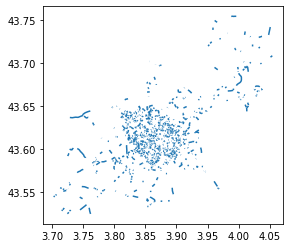

In [24]:
#comptages_an.plot()

In [22]:
#QT[['code_centrale','mja_jo']].plot(x=QT['code_centrale'])

## 1.3 représentation carto (couleur, épaisseur de trait)

In [23]:
comptages_an.to_crs('EPSG:2154',inplace=True)


In [24]:
comptages_an=comptages_an.to_crs('EPSG:2154')  # lambert 93 en mètres


In [25]:
comptages_an['troncon']=comptages_an.apply(lambda x: x['geometry'].buffer(max(10.0,200.0*x['mja_m']/100000)) , axis=1)
# épaisseur du tronçon selon le trafic : 200 mètres pour 100k vh/j

In [26]:
comptages_an=comptages_an.rename(columns={'gid':'code_centrale','maxspeed':'Vmaxi','nom_commun':'commune','name':'nom_de_voie'})

In [27]:
comptages_an.drop(['geometry'], axis=1, inplace=True)

In [28]:
comptages_an = gpd.GeoDataFrame(comptages_an, geometry='troncon')
comptages_an=comptages_an.set_crs('EPSG:2154')

In [29]:
comptages_an=comptages_an.to_crs('EPSG:4326') # conversion en 4326 pour JSON

In [30]:
def traficolor(d):
    if d < 1000:
        c = '#b1ee73'
    elif d < 5000:
        c = '#6dcd0c'  #62E04B 
    elif d < 15000:
        c = '#929a12'   #00CDA1 
    elif d < 30000:
        c = '#b66617'  # 0098FF
    elif d < 50000:
        c = '#db331c'  #6251D9 
    else: c = '#ff0022' #E80C24
    return c

In [31]:
comptages_an['color']=comptages_an.apply(lambda x: traficolor(x.mja_m),axis=1)

In [32]:
comptages_an.to_file(f"{TARGET_DIR}/trafic.geojson", driver='GeoJSON')